Source 
http://mc-stan.org/users/documentation/case-studies/radon.html?fbclid=IwAR3h_03XtQnyJQ18EOdREkPX-4biDX7c5AN5e9DPQzQLZ6hB2JRFh1gHemQ
http://mc-stan.org/users/documentation/case-studies/tutorial_rstanarm.html

# PROJECT WORK
#### 1. Problem Description 

The dataset named Star is obtained from the website http://vincentarelbundock.github.io/Rdatasets/datasets.html. The dataset is a collection of 5748 observations of individual performance in math and reading tests accross 79 different schools. The variables are class sizes, years of teaching experience, gender, qualified for free lunch and race. Below are 5 example instances of the original dataset:

![Data](./Fig/OriginalData.png)


For the scope of this project work, we focus on choosing only one variable and regress math scores based on that variable. The variable chosen here is years of teaching experience. Comparing the original distribution of math scores vs. log-scale of math scores, log-scale math scores seems to follow normal distribution better. Therefore, we choose to build our models with log-scale math scores. 

Data distribution:
![Math](./Fig/Math.png)


#### 2. Model description

In the sections following, we will go through 4 different models:

- Pooled model: all school belongs to the same distribution, log math scores is regressed based on years of teaching experience.  Parameters are beta1, beta2 and sigma that are common for all schools.  
                                        y ~ N(beta1 + beta2*x, sigma) 
- Separate model: each school has its own separate model. The parameters are alpha (unique for each school), beta and sigma (common for all schools)
                                        mu = alpha_school + beta*x
                                        y ~ N(mu, sigma)
- Varying slop and intercept model: each school has its own separate model with both alpha and beta unique for each school, sigma is common for all schools. Alpha and beta follows normal 
                                        alpha ~
                                        mu = alpha_school + beta_school*x
                                        y ~ N(mu, sigma)
- Hierarchical model: another prior level is added for alpha and beta. 
                                        mu_alpha ~ N(0,1)
                                        alpha ~ N(mu_alpha, sigma_alpha)
                                        beta ~ N(0,1)
                                        mu = 
                                        y ~ N(mu, sigma)

For evaluation purpose, we split up training-test data with the corresponding percentage 75-25 to evaluate the accuracy of each models. 

The codes are passed to PyStan and simulated with 2 chains in 1000 iterations. 

#### 2.1. Pooled model 

Stan code:

`data {
    int<lower=0>  N; //Number of train data
    int<lower=0> M; //Number of test data
    vector[N] x; // Variable - teaching experience
    vector[M] x_test; // Test variable 
    vector[N] y; // Labels - log math score
}
parameters {
    vector[2] beta;
    real<lower=0> sigma; //sigma is constrained to be positive 
}
model {
    y ~ normal(beta[1] + beta[2]*x, sigma); 
}
generated quantities{
    vector[N] log_lik;
    vector[M] y_pred_test;
    for (i in 1:M)
     y_pred_test[i] = normal_rng(beta[1] + beta[2]*x_test[i], sigma);
    for (i in 1:N)
     log_lik[i] = normal_lpdf(y[i]| beta[1] + beta[2]*x[i], sigma);
}`

#### 2.2. Separate model 

Stan code

`data{
    int<lower=0> N;
    int<lower=1, upper=79> school[N]; #school indicator
    vector[N] x;
    vector[N] y;
}
parameters {
    vector[79] alpha;
    real beta; 
    real<lower=0> sigma;
}
transformed parameters {
    vector[N] mu;  
    for (i in 1:N)
        mu[i] <- beta* x[i] + alpha[school[i]];
}
model {
    y ~ normal(mu, sigma);
}
generated quantities{
    vector[N] log_lik;
    for (i in 1:N)
     log_lik[i] = normal_lpdf(y[i]| mu[i], sigma);
}`

#### 2.5. Varying intercept and slope model 
Stan code:

    `data {
      int<lower=0> N;
      int<lower=0> J;
      vector[N] y;
      vector[N] x;
      int school[N];
    }
    parameters {
      real<lower=0> sigma;
      real<lower=0> sigma_a;
      real<lower=0> sigma_b;
      vector[J] a;
      vector[J] b;
      real mu_a;
      real mu_b;
    }

    model {
      mu_a ~ normal(0, 100);
      mu_b ~ normal(0, 100);

      a ~ normal(mu_a, sigma_a);
      b ~ normal(mu_b, sigma_b);
      y ~ normal(a[school] + b[school].*x, sigma);
    }`

#### 2.4. Hierarchical model 
Stan code:

#Stan code for hierarchical model 


#### 3. Convergence and Result
#### 3.1. Pooled model 

R-hat for all variables is approximately 1.0, so we can conclude that the model has converged. Checking effective sample size and divergence returns value True, meaning that there is no problem with the model. The graph below demonstrates the fitted line. 
![Pooledmodel](./Fig/Pooledmodel.png)


#### 3.2. Separate model  
R-hat for all variables is approximately 1.0, so we can conclude that the model has converged. Checking effective sample size and divergence returns value True, meaning that there is no problem with the model.
Alpha calculated for different schools (ordered from low to high):
![Sepmodel_alpha](./Fig/Sep_model_alpha.png)

#### 3.3. Varying intercept and slope model


#### 3.4. Hierarchical model  



#### 3. Model comparison and posterior predictive checking 

Two methods for model evaluation has been used in this project: psis-loo and MAE.

Psisloo results for each model:

| Measurements | Pooled model | Separate model | Varying intercept and slope | Hierarchical model |
| --- | --- | --- | --- | --- |
| psis-loo | 1985.8 | 2166.7 | --- | --- |
| p_eff | 3.1 | 80 | --- | --- |
| k < 0.7 | None | None | --- | --- |

Scatter plot of ks values for different models:


#### 5. Posterior predictive checking  
MAE and MSE results for each model:

| Measurements | Pooled model | Separate model | Varying intercept and slope | Hierarchical model |
| --- | --- | --- | --- | --- |
| MAE | --- | --- | --- | --- |
| MSE| --- | --- | --- | --- |

#### 6. Suggestion for development 
Further variables can be added to the model for better prediction result. 


In [43]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_context('notebook')
import stanity

In [44]:
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

In [45]:
star = pd.read_csv('Star.csv', index_col=0, header = 0)

In [46]:
star.head()


,tmathssk,treadssk,classk,totexpk,sex,freelunk,race,schidkn
2,473,447,small.class,7,girl,no,white,63
3,536,450,small.class,21,girl,no,black,20
5,463,439,regular.with.aide,0,boy,yes,black,19
11,559,448,regular,16,boy,no,white,69
12,489,447,small.class,5,boy,yes,white,79


In [47]:
len(np.unique(star.schidkn))

79

In [48]:
schools = star.schidkn.unique()

In [49]:
np.sort(schools)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80])

In [50]:
star.loc[star.schidkn>=78,'schidkn'] -= 1

In [51]:
schools = star.schidkn.unique()

In [52]:
df = pd.DataFrame()

In [53]:
for col in ['tmathssk', 'treadssk', 'totexpk', 'schidkn' ]:
    data = star.loc[:,col]
    df[col] = data
data = star.loc[:,['classk', 'sex', 'freelunk','race']]
df = df.merge(pd.get_dummies(data), left_index=True, right_index=True)

In [54]:
print(df.columns[[4, 6, 8]])
print(df.head())

Index(['classk_regular', 'classk_small.class', 'sex_girl'], dtype='object')
    tmathssk  treadssk  totexpk  schidkn  classk_regular  \
2        473       447        7       63               0   
3        536       450       21       20               0   
5        463       439        0       19               0   
11       559       448       16       69               1   
12       489       447        5       78               0   

    classk_regular.with.aide  classk_small.class  sex_boy  sex_girl  \
2                          0                   1        0         1   
3                          0                   1        0         1   
5                          1                   0        1         0   
11                         0                   0        1         0   
12                         0                   1        1         0   

    freelunk_no  freelunk_yes  race_black  race_other  race_white  
2             1             0           0           0           1  


In [55]:
df.drop(df.columns[[5, 7, 9, 12]], axis=1, inplace=True)

In [56]:
df.columns = ['math', 'reading', 'year_teaching', 'school','reg_class', 'sml_class', 'is_girl', 'free_lunch', 'black','white']

In [57]:
df.head()

,math,reading,year_teaching,school,reg_class,sml_class,is_girl,free_lunch,black,white
2,473,447,7,63,0,1,1,0,0,1
3,536,450,21,20,0,1,1,0,1,0
5,463,439,0,19,0,0,0,1,1,0
11,559,448,16,69,1,0,0,0,0,1
12,489,447,5,78,0,1,0,1,0,1


In [58]:
df.corr()['math'].sort_values()

free_lunch      -0.243111
black           -0.174493
reg_class       -0.036504
school           0.045439
sml_class        0.080078
is_girl          0.081041
year_teaching    0.096687
white            0.174968
reading          0.713549
math             1.000000
Name: math, dtype: float64

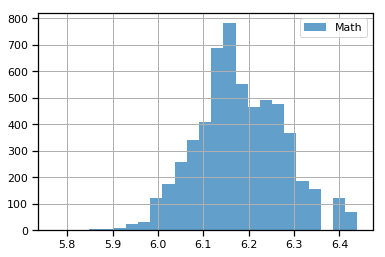

In [59]:
df.math.apply(lambda x:np.log(x)).hist(bins=25, alpha = 0.7, label = "Math") # Do we need to add +0.1?
plt.legend()
plt.show()


### Train/Test Split

In [60]:
X = df.drop('math', axis=1)
Y = np.log(df.math)

In [61]:
indices = range(df.shape[0])
i_schools = []
len_ischools = []

In [62]:
for s in schools:
    i_school = np.where(df.school == s)[0]
    len_ischools.append(len(i_school))
    i_schools.append(i_school)

In [63]:
min_len = min(len_ischools)
train_size = round(min_len*0.8)

In [64]:
train_idx = []
test_idx = []

In [65]:
for s in i_schools:
    np.random.shuffle(s)
    train_idx = np.concatenate((train_idx, s[:train_size]), axis=None)
    test_idx = np.concatenate((test_idx, s[train_size:]), axis=None)

In [66]:
len(train_idx)

2133

In [67]:
len(test_idx)

3615

In [68]:
X_train = X.iloc[train_idx,:]
X_test = X.iloc[test_idx,:].reset_index()
Y_train = Y.iloc[train_idx]
Y_test = Y.iloc[test_idx]

## Pooled model 

In [69]:
pooled_code = """
data {
    int<lower=0>  N;
    int<lower=0> M;
    vector[N] x;
    vector[M] x_test;
    vector[N] y;
}
parameters {
    vector[2] beta;
    real<lower=0> sigma;
}
model {
    y ~ normal(beta[1] + beta[2]*x, sigma);
}
generated quantities{
    vector[N] log_lik;
    vector[M] y_pred_test;
    for (i in 1:M)
     y_pred_test[i] = normal_rng(beta[1] + beta[2]*x_test[i], sigma);
    for (i in 1:N)
     log_lik[i] = normal_lpdf(y[i]| beta[1] + beta[2]*x[i], sigma);
}

"""

In [70]:
import pystan

pool_data = {
    'N': Y_train.shape[0], 
    'M': Y_test.shape[0],
    'x': X_train.loc[:,'year_teaching'],
    'x_test': X_test.loc[:,'year_teaching'],
    'y': Y_train,
}

In [71]:
pooled_fit = pystan.stan(model_code=pooled_code, data = pool_data, iter = 1000, chains = 2)
print(pooled_fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_174aac4ec68a4e0adc2676445f7b9556 NOW.
/opt/conda/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmprc65jxjt/stanfit4anon_model_174aac4ec68a4e0adc2676445f7b9556_873039916257682823.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


Inference for Stan model: anon_model_174aac4ec68a4e0adc2676445f7b9556.
2 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[1]             6.17  1.8e-4 3.8e-3   6.16   6.17   6.17   6.17   6.18    470    1.0
beta[2]           1.4e-3  1.5e-5 3.6e-4 7.1e-4 1.2e-3 1.4e-3 1.7e-3 2.1e-3    534    1.0
sigma                0.1  8.9e-5 1.5e-3   0.09   0.09    0.1    0.1    0.1    273    1.0
log_lik[1]          0.96  1.0e-3   0.02   0.91   0.94   0.96   0.97   1.01    549    1.0
log_lik[2]          0.73  1.0e-3   0.03   0.67   0.71   0.73   0.75   0.79    840    1.0
log_lik[3]          1.12  7.9e-4   0.02   1.08   1.11   1.12   1.13   1.16    565    1.0
log_lik[4]          1.42  9.4e-4   0.02   1.39   1.41   1.42   1.43   1.45    273    1.0
log_lik[5]          1.26  6.4e-4   0.02   1.22   1.24   1.26   1.27   1.29    737    1.0
log_lik[6]  

In [72]:
pystan.diagnostics.check_n_eff(pooled_fit)

True

In [73]:
pystan.diagnostics.check_div(pooled_fit)

True

psisloo:  1985.8431635962008
3.105263704652316


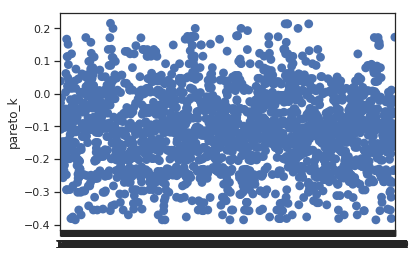

In [108]:
pooled_sample = pooled_fit.extract(permuted=True)

loglik = (pooled_sample["log_lik"])
psisloo = stanity.psisloo(loglik)
print("psisloo: ",psisloo.elpd)
psisloo.plot()
lppd_pooled = 0 
for i in range (Y_train.shape[0]):
    lppd_pooled = lppd_pooled + np.log(np.mean(np.exp(loglik[:,i])))

peff_pooled = np.sum(lppd_pooled) - psisloo.elpd
print("p_eff: ", peff_pooled)


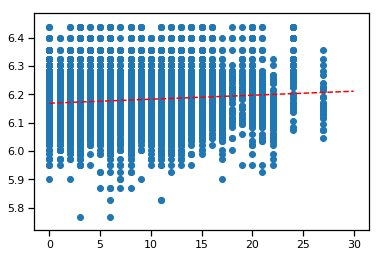

In [75]:
b0, m0 = pooled_sample['beta'].T.mean(1)
plt.scatter(df.year_teaching, np.log(df.math))
xvals = np.linspace(0,30)
plt.plot(xvals, m0*xvals+b0, 'r--')
plt.show()


In [76]:
#Comparing y_pred with y_test
y_pred = np.mean(pooled_sample["y_pred_test"], axis=0)
round(MAE(Y_test, y_pred),3)

0.078

In [77]:
round(MSE(Y_test, y_pred),3)

0.01

##  Separate model

In [78]:
separate_code = """
data{
    int<lower=0> N;
    int<lower=1, upper=79> school[N]; #school indicator
    vector[N] x;
    vector[N] y;
}
parameters {
    vector[79] alpha;
    real beta; #only 1 beta, not a vector
    real<lower=0> sigma;
}
transformed parameters {
    vector[N] y_hat;  
    for (i in 1:N)
        y_hat[i] <- beta* x[i] + alpha[school[i]];
}
model {
    y ~ normal(y_hat, sigma);
}
generated quantities{
    vector[N] log_lik;
    for (i in 1:N)
     log_lik[i] = normal_lpdf(y[i]| y_hat[i], sigma);
}
"""

In [79]:
separate_data = {'N': X_train.shape[0],
                 'school': X_train.school,
                 'x': X_train.loc[:,'year_teaching'],
                 'y': Y_train }

In [80]:
separate_fit = pystan.stan(model_code = separate_code, data = separate_data, iter = 1000, chains = 2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0658457e53e8959415aa44ade4e33d07 NOW.
/opt/conda/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpyyab1hou/stanfit4anon_model_0658457e53e8959415aa44ade4e33d07_3382930902046694746.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [81]:
print(separate_fit)
separate_sample = separate_fit.extract(permuted=True)


Inference for Stan model: anon_model_0658457e53e8959415aa44ade4e33d07.
2 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha[1]         6.2  3.9e-4   0.02   6.17   6.19    6.2   6.22   6.24   1869    1.0
alpha[2]        6.11  4.7e-4   0.02   6.07    6.1    6.1   6.12   6.14   1256    1.0
alpha[3]         6.2  4.1e-4   0.02   6.16   6.19    6.2   6.21   6.23   1780    1.0
alpha[4]        6.15  4.1e-4   0.02   6.12   6.14   6.15   6.16   6.18   1607    1.0
alpha[5]        6.13  4.1e-4   0.02    6.1   6.12   6.13   6.14   6.16   1650    1.0
alpha[6]        6.14  4.2e-4   0.02   6.11   6.13   6.14   6.15   6.18   1510    1.0
alpha[7]        6.23  3.5e-4   0.02    6.2   6.22   6.23   6.24   6.26   1991    1.0
alpha[8]        6.18  3.9e-4   0.02   6.15   6.17   6.18   6.19   6.21   1847    1.0
alpha[9]        6.18  4.9e-4   0.02   6.14   6.1

In [82]:
print("N_eff check : ",pystan.diagnostics.check_n_eff(pooled_fit))
print("Divergence check: ", pystan.diagnostics.check_div(pooled_fit))

N_eff check :  True
Divergence check:  True


In [83]:
alpha = np.mean(separate_fit['alpha'], axis=0)
beta = np.mean(separate_fit['beta'])

psisloo:  2166.67171133834
p_eff:  80.35145330473142


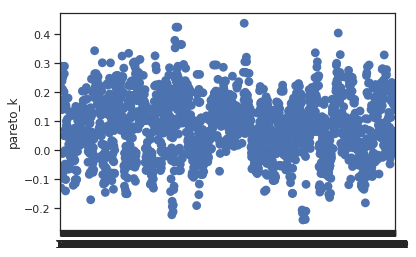

In [121]:
separate_sample = separate_fit.extract(permuted=True)

loglik = (separate_sample["log_lik"])
psisloo = stanity.psisloo(loglik)
print("psisloo: ",psisloo.elpd)
psisloo.plot()
lppd_pooled = 0 
for i in range (Y_train.shape[0]):
    lppd_pooled = lppd_pooled + np.log(np.mean(np.exp(loglik[:,i])))

peff_pooled = np.sum(lppd_pooled) - psisloo.elpd
print("p_eff: ", peff_pooled)

In [84]:
Y_pred = []
for i in range(X_test.shape[0]):
    school = X_test.loc[i, 'school']
    Y_pred.append(alpha[school-1] + beta*X_test.loc[i, 'year_teaching'])

In [85]:
MAE(Y_pred, Y_test)

0.06960108008263635

In [86]:
MSE(Y_pred, Y_test)

0.007860359752948584

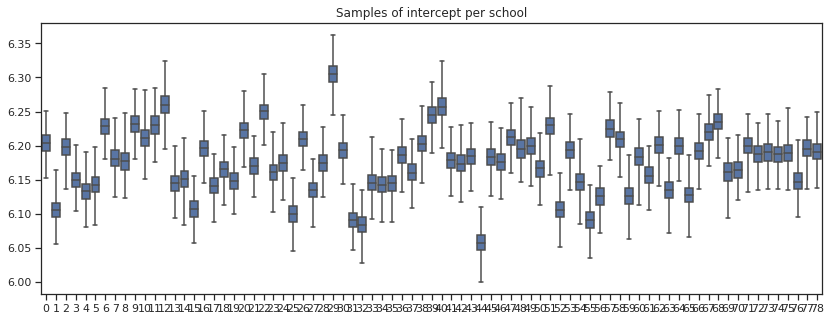

In [122]:
import seaborn as sns
sns.set(style="ticks")

a_sample = pd.DataFrame(separate_fit['alpha'])
plt.figure(figsize=(14, 5))
sns.boxplot(data=a_sample, whis=np.inf, color="b")
plt.title("Samples of intercept per school")
plt.show()


# Varying intercept and slope model

In [89]:
varying_intercept_slope = """
data {
  int<lower=0> N;
  int<lower=0> J;
  vector[N] y;
  vector[N] x;
  int school[N];
}
parameters {
  real<lower=0> sigma;
  real<lower=0> sigma_a;
  real<lower=0> sigma_b;
  vector[J] a;
  vector[J] b;
  real mu_a;
  real mu_b;
}

model {
  mu_a ~ normal(0, 100);
  mu_b ~ normal(0, 100);

  a ~ normal(mu_a, sigma_a);
  b ~ normal(mu_b, sigma_b);
  y ~ normal(a[school] + b[school].*x, sigma);
}
"""

In [90]:
varying_intercept_slope_data = {'N': df.shape[0],
                          'J': 79,
                          'school': star.schidkn,
                          'x': df.loc[:,'year_teaching'],
                          'y': np.log(df.math)}

varying_intercept_slope_fit = pystan.stan(model_code=varying_intercept_slope, 
                                          data=varying_intercept_slope_data, 
                                          iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a84c8a70d43b509c9ad81e510737ff63 NOW.
/opt/conda/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmp9wst3l6y/stanfit4anon_model_a84c8a70d43b509c9ad81e510737ff63_554837982455241419.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


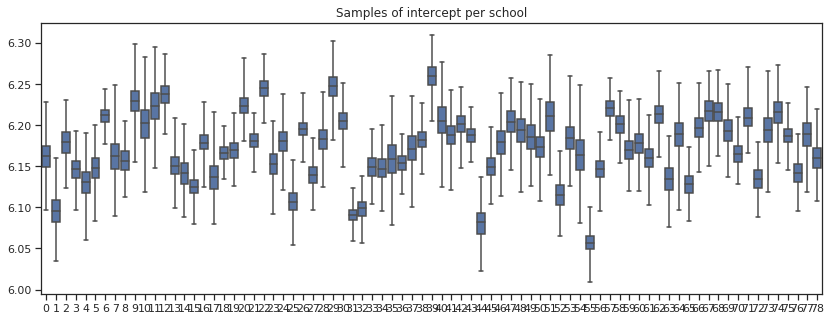

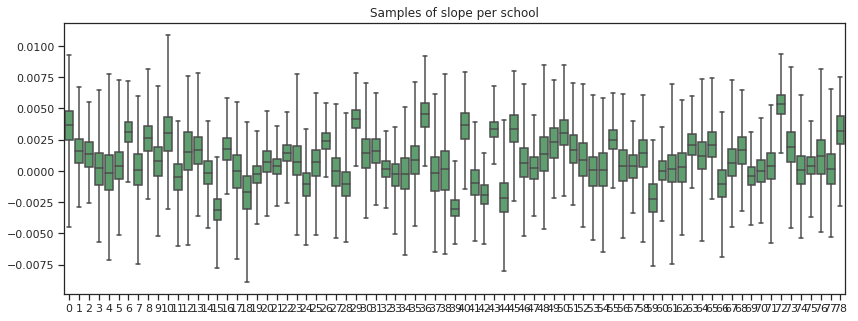

In [119]:
import seaborn as sns
sns.set(style="ticks")

a_sample = pd.DataFrame(varying_intercept_slope_fit['a'])
plt.figure(figsize=(14, 5))
sns.boxplot(data=a_sample, whis=np.inf, color="b")
plt.title("Samples of intercept per school")
plt.show()

b_sample = pd.DataFrame(varying_intercept_slope_fit['b'])
plt.figure(figsize=(14, 5))
sns.boxplot(data=b_sample, whis=np.inf, color = 'g')
plt.title("Samples of slope per school")
plt.show()


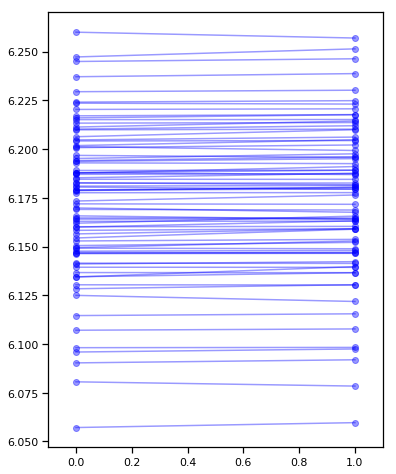

In [91]:
xvals = np.arange(2)
b = varying_intercept_slope_fit['a'].mean(axis=0)
m = varying_intercept_slope_fit['b'].mean(axis=0)
plt.figure(figsize=(6,8))
for bi,mi in zip(b,m):
    plt.plot(xvals, mi*xvals + bi, 'bo-', alpha=0.4)
plt.xlim(-0.1, 1.1);

## Hierarchical model

In [94]:
hierarchical_code = """
data{
    int<lower=0> N;
    int<lower=1, upper=79> K; 
    matrix[N, K] x;
    matrix[N, k] y;
}
parameters {
    real betapred;
    real alphapred;
    vector[79] alpha;
    real beta; #only 1 beta, not a vector
    real<lower=0> sigma;
}
transformed parameters {
    vector[N] y_hat;  
    for (i in 1:N)
        y_hat[i] <- beta* x[i] + alpha[school[i]];
}
model {
    y ~ normal(y_hat, sigma);
}
generated quantities{
    vector[N] log_lik;
    for (i in 1:N)
     log_lik[i] = normal_lpdf(y[i]| y_hat[i], sigma);
}
"""